In [207]:
import os
import sys
import pickle
import random
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order


sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

steps = 5

def test_4_stationary(X):
    result = adfuller(X, autolag='AIC')
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in result[4].items():
        print(' - %s: %.3f' % (key, value))
    print(f"Is the time series stationary? {pvalue < 0.05}")
    return pvalue < 0.05

def test_4_cointegration(y1, y2, trend="c", maxlag=15):
    result = coint(y1, y2, trend=trend, maxlag=maxlag)
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in zip([1, 5, 10], result[2]):
        print(f' - {key}%: {round(value, 3)}')
    print(f"Is time series cointegrate? {pvalue < 0.05}")
    return pvalue < 0.05

def autoregression_model(y1, y2, columns):
    print("Augmented Dickey-Fuller Test:")
    print("-" * 30)
    print()

    print(f"{columns[0]}:")
    print("-" * 30)
    y1_is_stationary = test_4_stationary(y1)

    print()
    print(f"{columns[1]}:")
    print("-" * 30)
    y2_is_stationary = test_4_stationary(y2)

    print()
    print()
    print("Engle-Granger Test:")
    print("-" * 30)
    print()
    is_cointegrate = test_4_cointegration(y1, y2)
    print()
    
    
    result = None
    df_int_ = pd.DataFrame(np.c_[y1, y2], columns=columns)
    # VECM
    if (not y1_is_stationary and not y2_is_stationary) and is_cointegrate:
        result = VECM(df_int_, k_ar_diff=30).fit()
        print(result.test_granger_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    # VAR
    elif (y1_is_stationary and y2_is_stationary) and is_cointegrate:
        result = VAR(df_int_).fit(ic="aic")
        print(result.test_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    else:
        print("!!! Can find a model that could fit the series, please make the series stationary !!!")
    return result
    

normalizar = CleanUp(remove_stopwords=True)

In [4]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-15.csv")

covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

# print(df_covid.columns)

In [5]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [6]:
# print(hashtags_.columns)
# print(users_.columns)

## Informações da base de dados

In [8]:
print(f"Qtde. de Comentários            : {len(hashtags_)}")
print(f"Qtde. de Comentários positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentários negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuários geolocalizados: {len(users_)}")
print(f"Qtde. de Usuários em SP         : {len(users_[users_['state'] == 'SP'])}")
print(f"Qtde. de Usuários em RJ         : {len(users_[users_['state'] == 'RJ'])}")

Qtde. de Comentários            : 250385
Qtde. de Comentários positivos  : 85995
Qtde. de Comentários negativos  : 164390
----------------------------------------
Qtde. de Usuários geolocalizados: 62336
Qtde. de Usuários em SP         : 12304
Qtde. de Usuários em RJ         : 12914


Exemplos de comentários com suas classificações:

In [9]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"{row.classify}|{row.comment}")

negativo|Fora do normal o quanto eu estou com saudades do meu padrinho e não posso ir vê-lo por causa desse corona
negativo|caras falta de ar é sintoma do coronga?
negativo|Em resposta a  @QuebrandoOTabu  e  @letrapreta Eu tive que trabalhar durante a pandemia, agora estou em isolamento com Covid, quando vão abrir os olhos para realidade? Precisamos de lockdown já!
negativo|Em resposta a  @dantegalileu Eu já fui essa criança (e sou assim até hj), vivo tendo dor de garganta kakakakaka
negativo|apesar dos sonhos agitados e com falta de ar eu tbm tenho sonhado muito com meu avô e sempre eh uma sensação mt boa


## Nuvens de palavras

Nuvem de palavras de todos os comentários na base de dados.

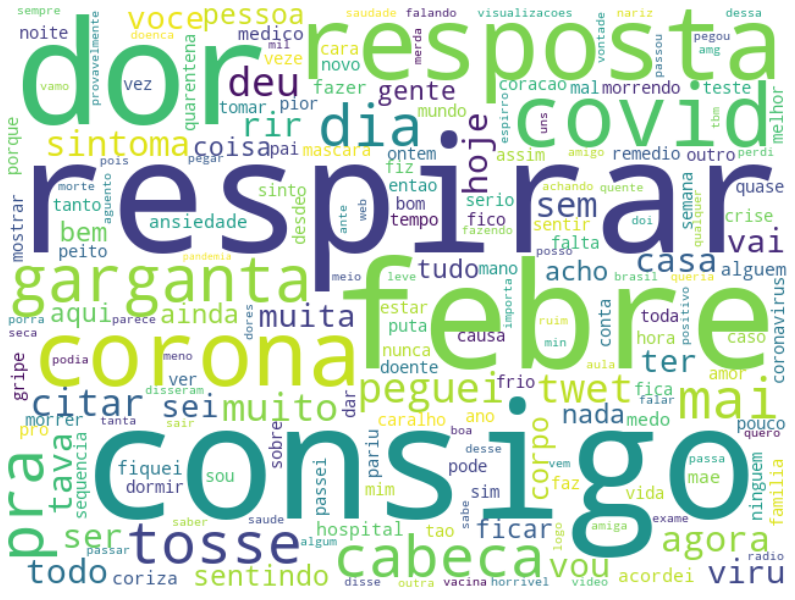

In [7]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nuvens de palavras apenas de comentários classificados como positivos.

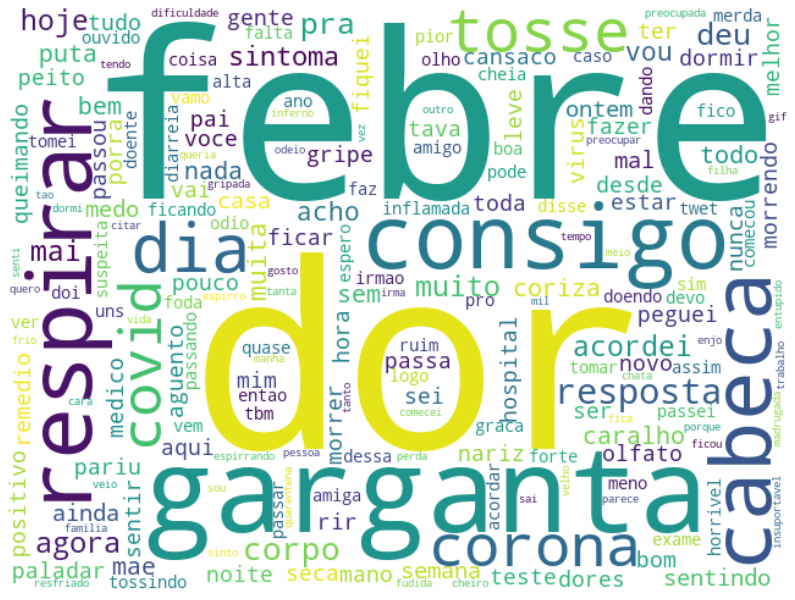

In [8]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizações dos dados

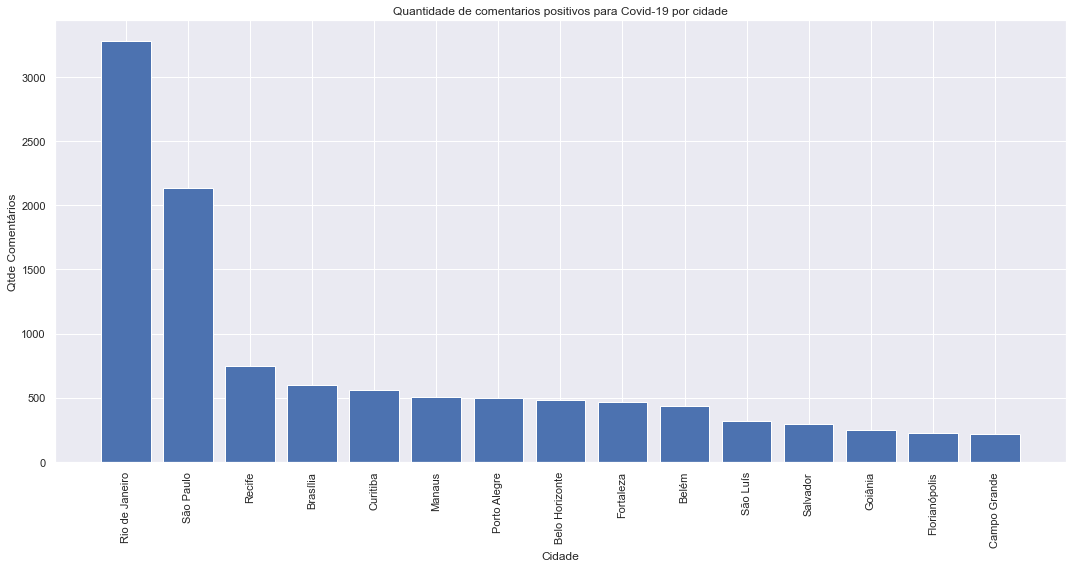

In [192]:
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

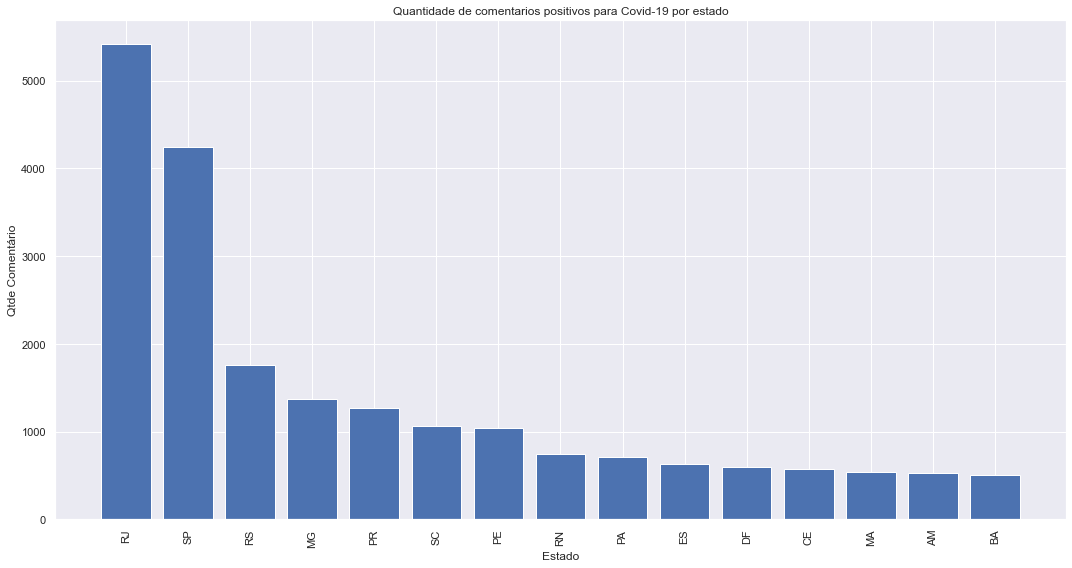

In [193]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Qtde Comentário")
plt.tight_layout()
plt.show()

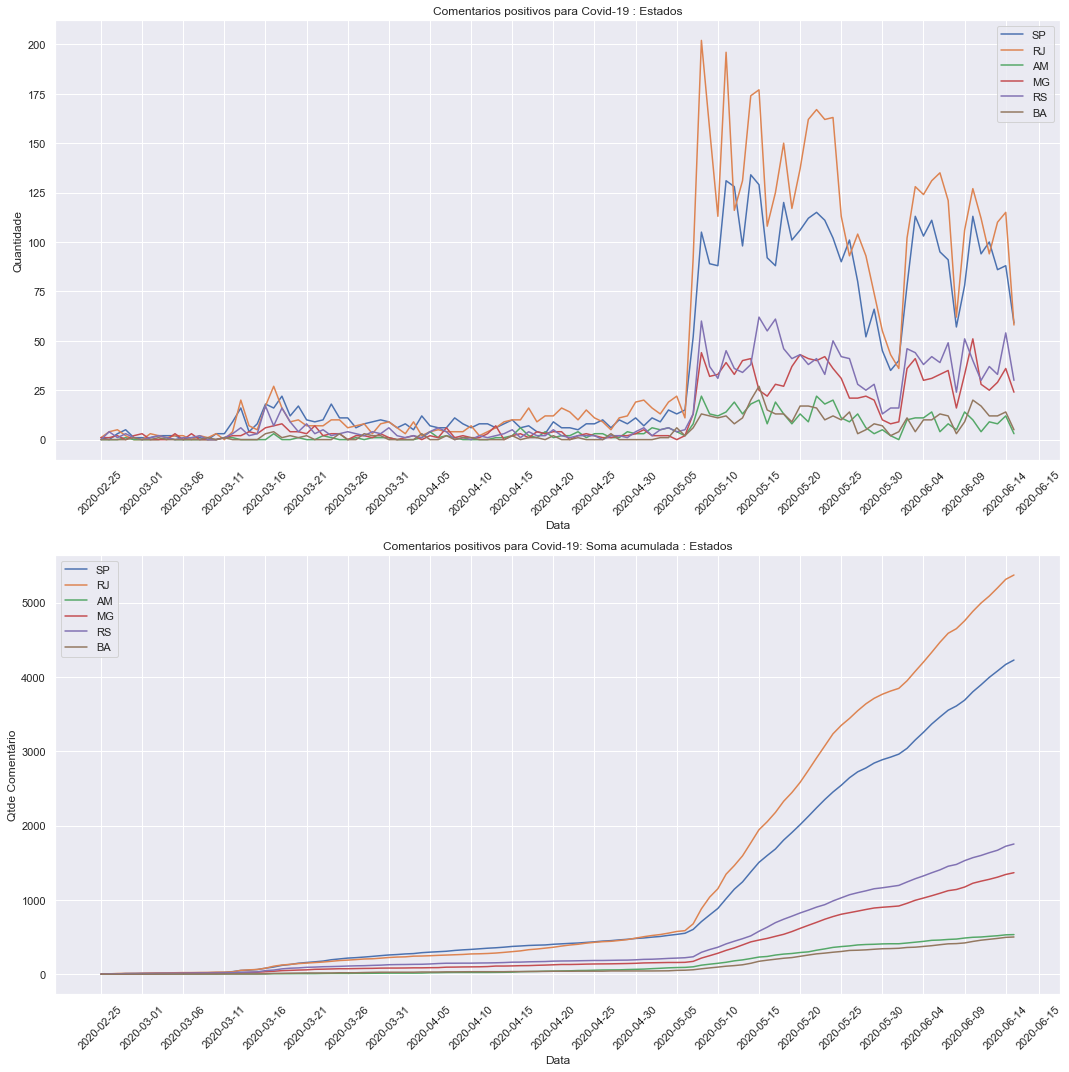

In [194]:
usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)


datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

steps = 5
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Qtde Comentário")
plt.legend()
plt.tight_layout()
plt.show()

In [208]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])
df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

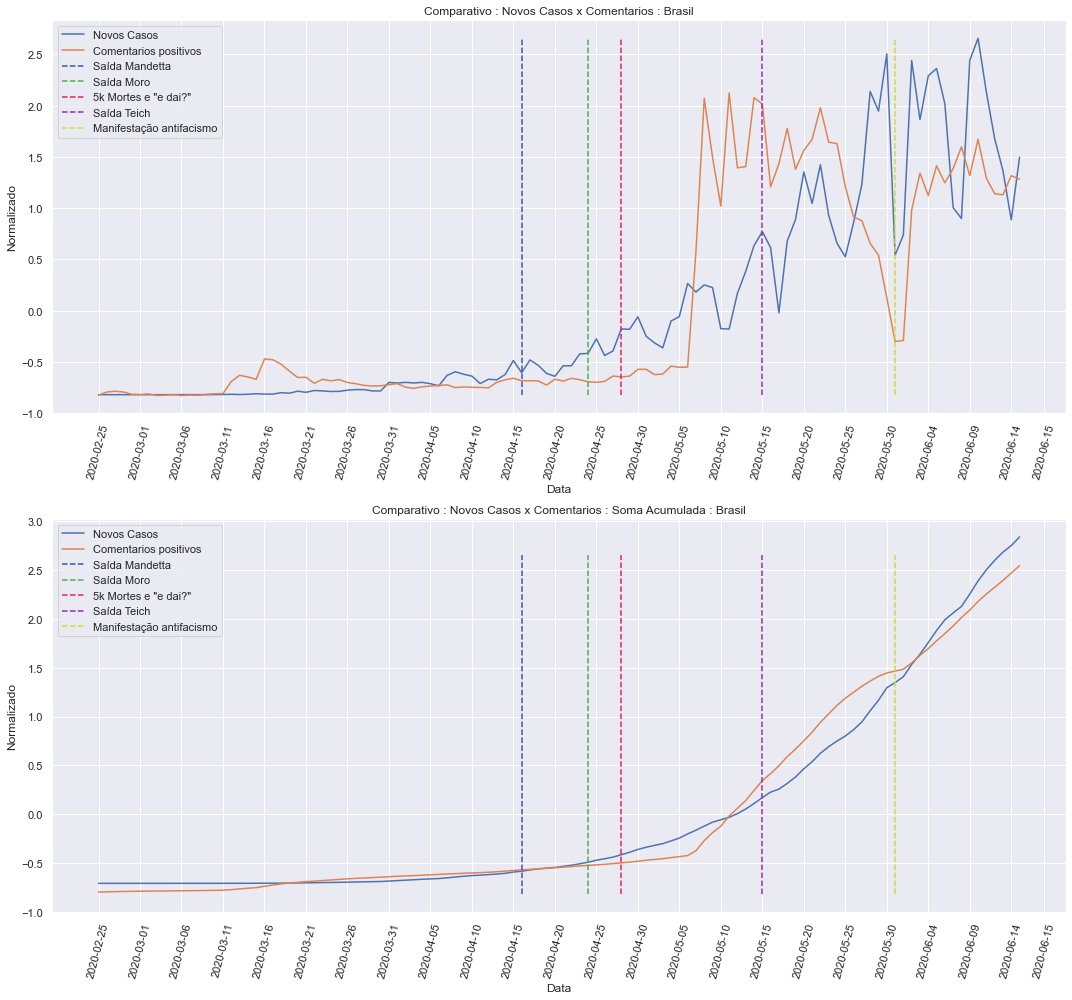

In [209]:
calc_novos_casos = df_merged["newCases"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novos_casos = scale(calc_novos_casos)
numero_comments = scale(calc_numero_comments)
cumsum_novos_casos = scale(np.cumsum(calc_novos_casos))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Novos Casos x Comentarios : Brasil")
plt.plot(tempo, novos_casos, label="Novos Casos")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Novos Casos x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novos_casos, label="Novos Casos")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")

plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [210]:
autoregression_model(numero_comments, novos_casos, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.378059
p-value: 0.592748
Critical Values:
 - 1%: -3.492
 - 5%: -2.889
 - 10%: -2.581
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 0.760653
p-value: 0.990974
Critical Values:
 - 1%: -3.495
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -3.099826
p-value: 0.088338
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


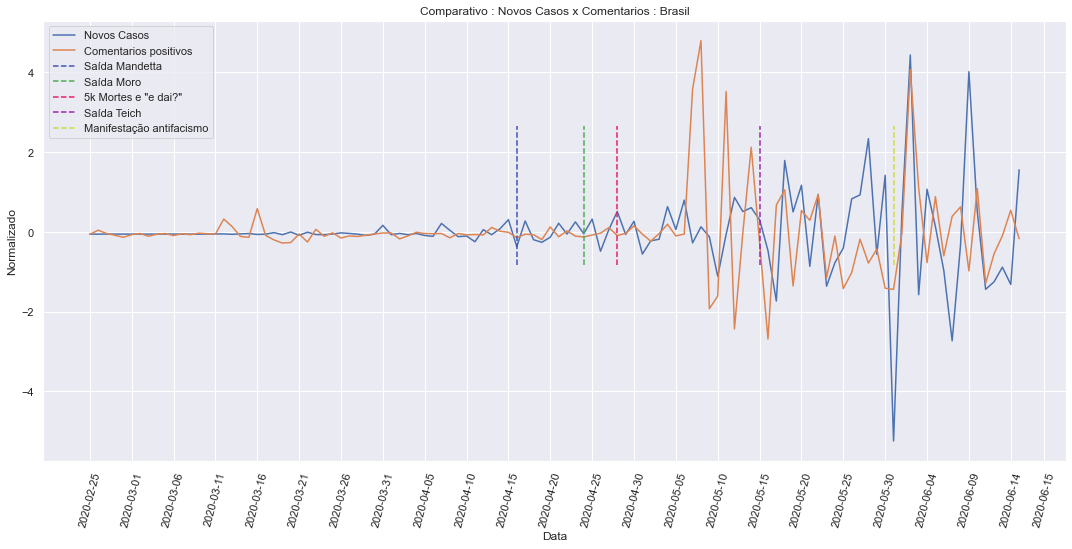

In [211]:
stat_calc_novos_casos = df_merged["stationary_newCases"] / 212_000_000
stat_calc_numero_comments = (df_merged["stationary_numComments"] * 0.75) / 8_280_000
stat_novos_casos = scale(stat_calc_novos_casos)
stat_numero_comments = scale(stat_calc_numero_comments)

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Novos Casos x Comentarios : Brasil")
plt.plot(tempo, stat_novos_casos, label="Novos Casos")
plt.plot(tempo, stat_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [212]:
result = autoregression_model(stat_numero_comments, stat_novos_casos, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -5.563505
p-value: 0.000002
Critical Values:
 - 1%: -3.492
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? True

Casos:
------------------------------
ADF Statistic: -3.589975
p-value: 0.005956
Critical Values:
 - 1%: -3.495
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? True


Engle-Granger Test:
------------------------------

ADF Statistic: -5.392792
p-value: 0.000029
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? True

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.341          1.817   0.201 (12, 150)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not i

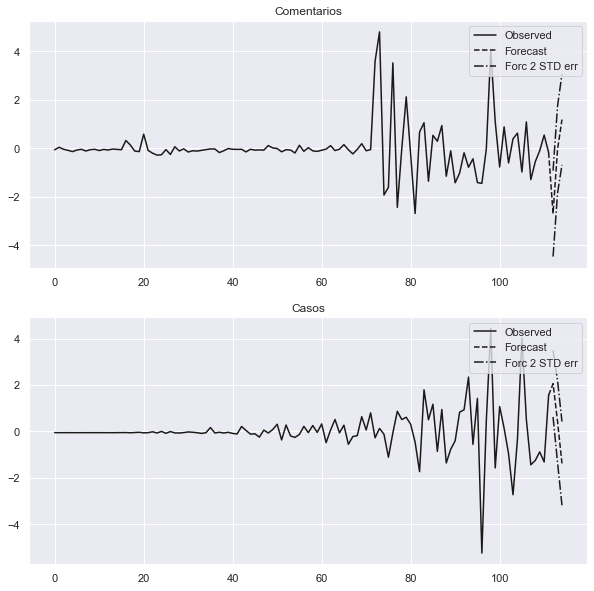

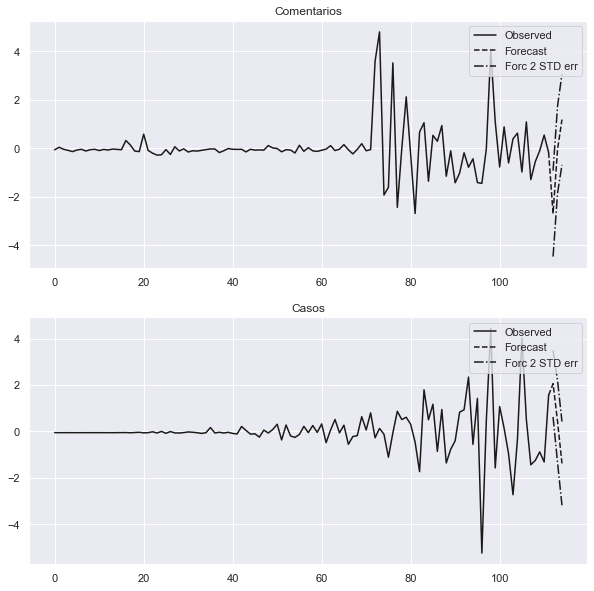

In [213]:
result.plot_forecast(steps=3)

In [238]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])
df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

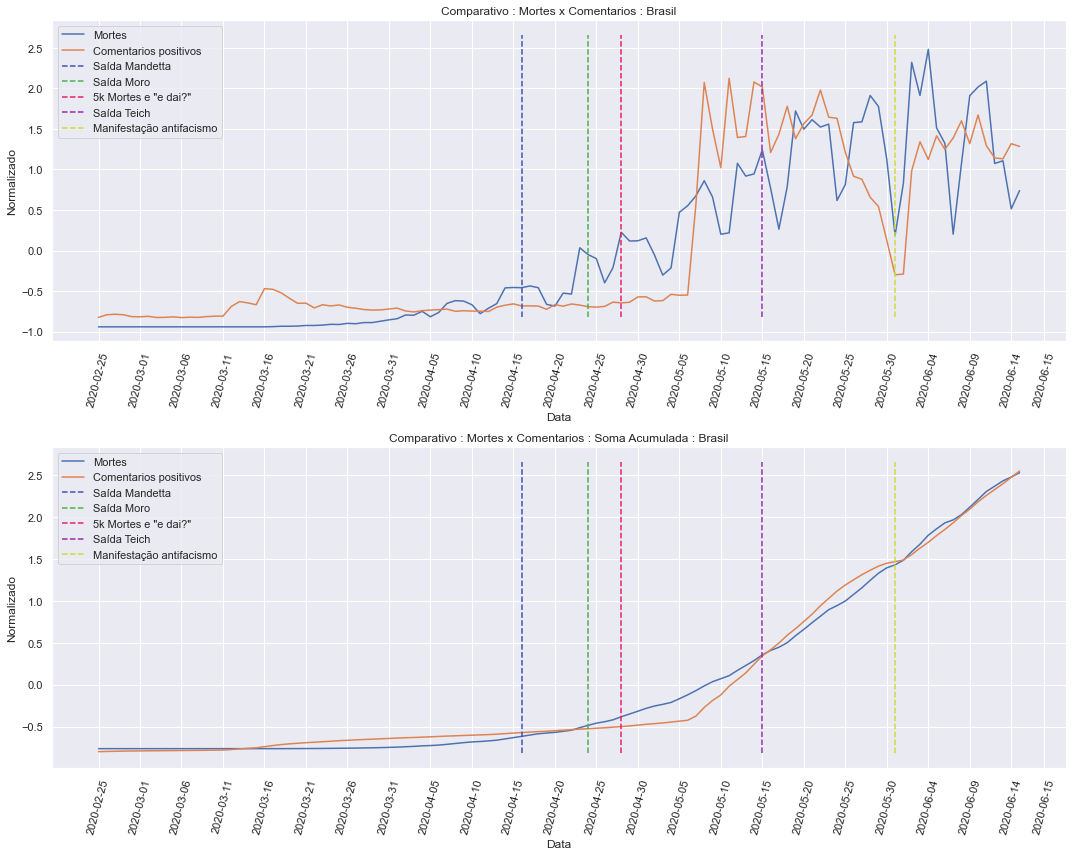

In [239]:
calc_novas_mortes = df_merged["newDeaths"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novas_mortes = scale(calc_novas_mortes)
numero_comments = scale(calc_numero_comments)
cumsum_novas_mortes = scale(np.cumsum(calc_novas_mortes))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Mortes x Comentarios : Brasil")
plt.plot(tempo, novas_mortes, label="Mortes")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Mortes x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novas_mortes, label="Mortes")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [240]:
result = autoregression_model(numero_comments, novas_mortes, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.378059
p-value: 0.592748
Critical Values:
 - 1%: -3.492
 - 5%: -2.889
 - 10%: -2.581
Is the time series stationary? False

Mortes:
------------------------------
ADF Statistic: 0.151111
p-value: 0.969382
Critical Values:
 - 1%: -3.499
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -3.467047
p-value: 0.035431
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? True

Granger causality F-test. H_0: Comentarios does not Granger-cause Mortes. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         10.96          1.810   0.000 (31, 32)
----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantane

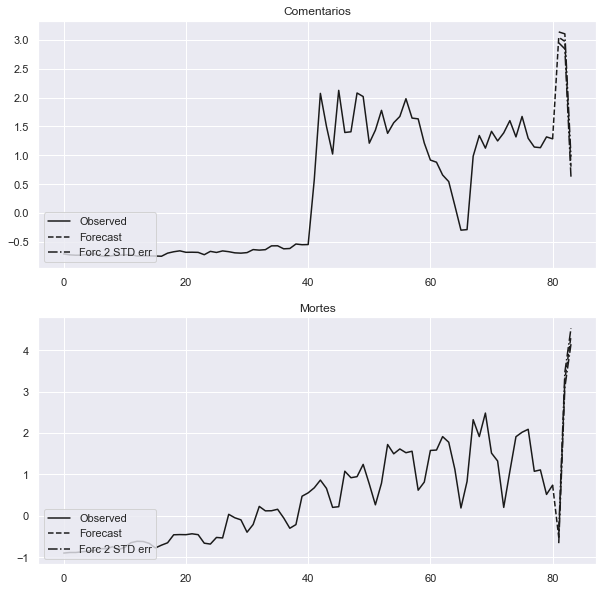

In [241]:
result.plot_forecast(steps=3)

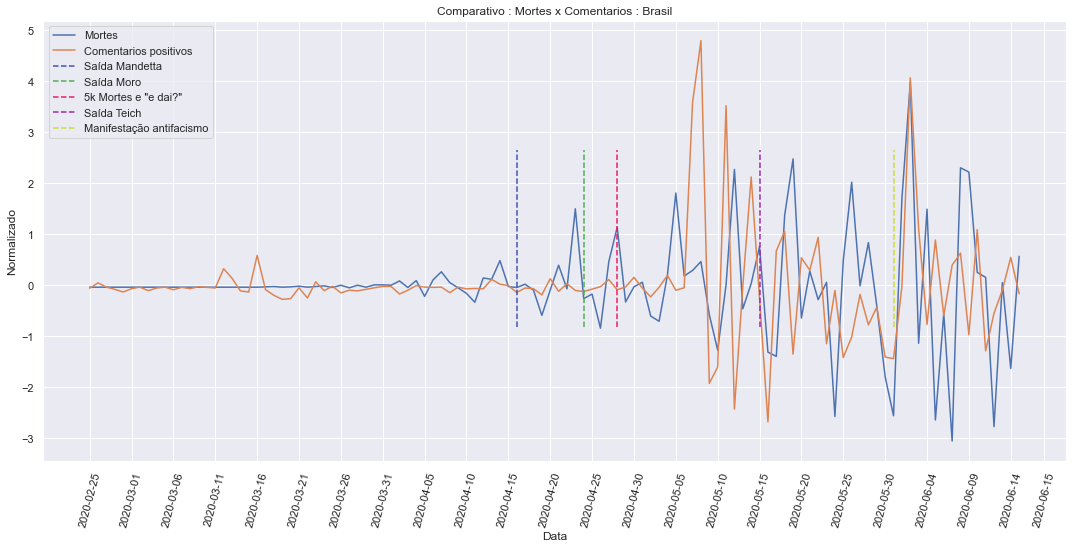

In [242]:
stat_calc_novas_mortes = df_merged["stationary_newDeaths"] / 212_000_000
stat_calc_numero_comments = (df_merged["stationary_numComments"] * 0.75) / 8_280_000
stat_novas_mortes = scale(stat_calc_novas_mortes)
stat_numero_comments = scale(stat_calc_numero_comments)

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Mortes x Comentarios : Brasil")
plt.plot(tempo, stat_novas_mortes, label="Mortes")
plt.plot(tempo, stat_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [243]:
result = autoregression_model(stat_calc_novas_mortes, stat_calc_numero_comments, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.891153
p-value: 0.336234
Critical Values:
 - 1%: -3.499
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? False

Mortes:
------------------------------
ADF Statistic: -5.563505
p-value: 0.000002
Critical Values:
 - 1%: -3.492
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? True


Engle-Granger Test:
------------------------------

ADF Statistic: -1.117721
p-value: 0.878151
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!
